In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
import pmdarima as pm
import itertools
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("C:/Users/mrrai/Downloads/cpi_Austria.csv")
print(df.head())

# Exercise 1: a
df['Date'] = pd.to_datetime(df['Date'] + '-01')
df['year'] = df['Date'].dt.year
data = df.groupby('year')['CPI'].mean().reset_index(name='cpi_avg')
data = data[data['year'] != 2025]

      Date       CPI
0  1959-02 -0.500988
1  1959-03 -0.401206
2  1959-04 -1.283307
3  1959-05 -1.851812
4  1959-06  0.682282


In [3]:
print(data.head())

   year   cpi_avg
0  1959  1.229034
1  1960  1.956280
2  1961  3.541323
3  1962  4.390914
4  1963  2.717900


In [4]:
p = range(0, 5)
q = range(0, 5)
pq_arma = list(itertools.product(p,range(1),q))
pq_arma

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (4, 0, 0),
 (4, 0, 1),
 (4, 0, 2),
 (4, 0, 3),
 (4, 0, 4)]

In [5]:
for param in pq_arma: 
    ARMA_model = ARIMA(data['cpi_avg'], order=param).fit()
    print('ARMA({},{}) - HQIC:{}'.format(param[0],param[2], ARMA_model.hqic))

ARMA(0,0) - HQIC:290.9180766192647
ARMA(0,1) - HQIC:251.14981696978282
ARMA(0,2) - HQIC:246.4353586226275
ARMA(0,3) - HQIC:246.832926374476
ARMA(0,4) - HQIC:248.464429975453
ARMA(1,0) - HQIC:243.28403042670402
ARMA(1,1) - HQIC:242.48127378672334
ARMA(1,2) - HQIC:243.9384496542792
ARMA(1,3) - HQIC:246.7026758412817
ARMA(1,4) - HQIC:249.55539192788095
ARMA(2,0) - HQIC:244.20188904080013
ARMA(2,1) - HQIC:244.57315195715717
ARMA(2,2) - HQIC:246.69053244425373
ARMA(2,3) - HQIC:249.55330101719682
ARMA(2,4) - HQIC:252.4185828211898
ARMA(3,0) - HQIC:244.29840842849646
ARMA(3,1) - HQIC:246.93393581401543
ARMA(3,2) - HQIC:249.55315955351696
ARMA(3,3) - HQIC:252.41850733217473
ARMA(3,4) - HQIC:255.30213436455432
ARMA(4,0) - HQIC:247.03652683955244
ARMA(4,1) - HQIC:249.7292645144707
ARMA(4,2) - HQIC:252.41837566421674
ARMA(4,3) - HQIC:250.17325227058842
ARMA(4,4) - HQIC:255.1353901567692


In [6]:
# Exercise 1c
best_model = ARIMA(data['cpi_avg'],order = (1,0,1))
results = best_model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2431      0.633      5.122      0.000       2.002       4.484
ar.L1          0.5478      0.134      4.088      0.000       0.285       0.810
ma.L1          0.4040      0.135      2.997      0.003       0.140       0.668
sigma2         1.9122      0.271      7.064      0.000       1.382       2.443


## Discussion
The autoregressive term (AR.L1) coefficient is 0.55 and the moving average term (MA.L1) coefficient is 0.40. Both are statistically significant (p-values < 0.01), indicating that the previous year's CPI average and the previous year's error term are important predictors of the current year's average CPI.

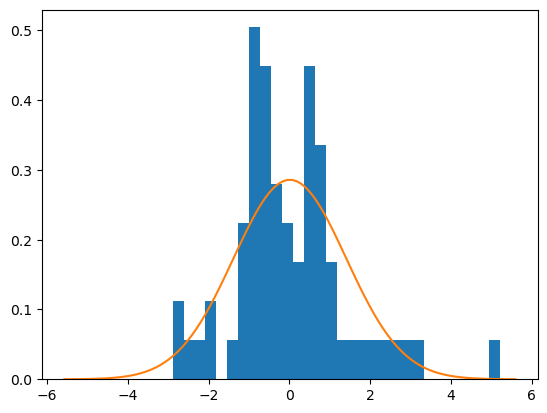

In [8]:
# Exercise 2a
residuals = results.resid
plt.hist(residuals, bins=30, density=True)
mu, std = np.mean(residuals), np.std(residuals)
x = np.linspace(mu - 4*std, mu + 4*std, 100)
pdf = stats.norm.pdf(x, mu, std)
plt.plot(x, pdf);

## Discussion
This plot displays a distribution of the residuals from the ARMA(1,1) model, overlaid with a theoretical normal distribution curve. Visually, the residuals are roughly centered around zero. However, the distribution appears somewhat more peaked in the center and has slightly heavier tails compared to the normal curve. While not perfectly matching the normal distribution, it suggests the normality assumption for the residuals is approximately met.

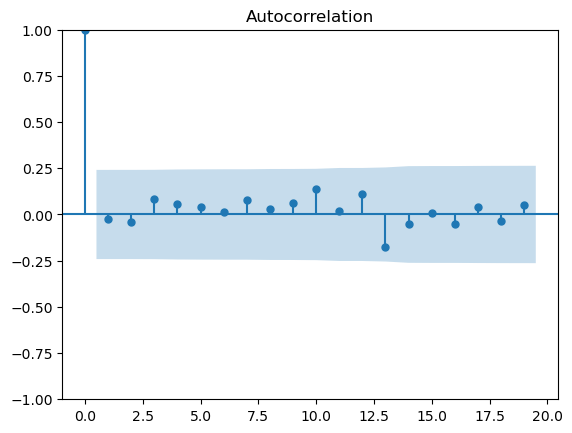

In [10]:
# Exercise 2b
plot_acf(residuals);

## Discussion
This plot displays the Autocorrelation Function (ACF) for the residuals of the ARMA(1,1) model, showing the correlation between the residuals and their values at previous lags. The blue shaded area represents the 95% confidence interval. We observe that all autocorrelation spikes for lags greater than 0 fall well within this confidence interval. This indicates that there is no statistically significant autocorrelation remaining in the residuals. The residuals behave like white noise, which supports the conclusion that the ARMA(1,1) model has adequately captured the autocorrelation structure present in the original data.

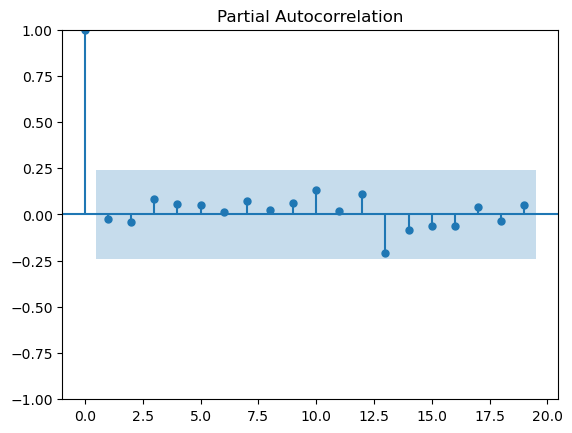

In [12]:
plot_pacf(residuals);

## Discussion
This plot displays the Partial Autocorrelation Function (PACF) for the residuals of the ARMA(1,1) model. It measures the correlation between the residuals and their lagged values after removing the effects of correlations at shorter lags. The blue shaded area represents the 95% confidence interval. As observed, all PACF spikes for lags greater than 0 fall within or very close to the confidence interval. This lack of significant spikes suggests that there is no remaining partial autocorrelation in the residuals. This finding, along with the ACF results, reinforces that the residuals behave like white noise, supporting the adequacy of the fitted ARMA(1,1) model.

In [14]:
# Exercise 2c
ljung_box= acorr_ljungbox(residuals, lags=[10], boxpierce=True)
print(ljung_box)

     lb_stat  lb_pvalue   bp_stat  bp_pvalue
10  3.371813   0.971273  2.903865   0.983597


## Discussion
Both p-values are substantially larger than the conventional significance level. Therefore, we fail to reject the null hypothesis which states that there is no autocorrelation in the residuals. This suggests that there is no statistically significant evidence of autocorrelation remaining in the model residuals up to lag 10. This outcome supports the adequacy of the ARMA(1,1) model fit.

In [16]:
# Exercise 2d
from statsmodels.stats.diagnostic import acorr_lm 
lm_test = acorr_lm(residuals, nlags=10)  
print(f"LM Statistic: {lm_test[0]}")
print(f"P-value: {lm_test[1]}")

LM Statistic: 3.6488722069149278
P-value: 0.961800138671248


## Discussion
The LM test was performed on the ARMA(1,1) model residuals to check for serial correlation up to lag 10. The null hypothesis of this test is that there is no serial correlation. The resulting p-value of approximately 0.96 is very high, indicating that we fail to reject the null hypothesis at conventional significance levels. Therefore, this test provides no evidence of significant serial correlation remaining in the residuals, further supporting the adequacy of the ARMA(1,1) model.

In [18]:
# Exercise 3a
length_trainingset = data[data['year'] <= 2022].index[-1]
train, test = data.loc[:length_trainingset, 'cpi_avg'], data.loc[length_trainingset + 1:, 'cpi_avg']
best_model = pm.auto_arima(train, start_p=0, start_q=0, max_p=5, max_q=5, d = 0,                                 seasonal=False, trace=True, information_criterion = 'hqic')
arma_model = best_model.fit(train)
print(arma_model.summary().tables[1])

Performing stepwise search to minimize hqic
 ARIMA(0,0,0)(0,0,0)[0]             : HQIC=357.363, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : HQIC=233.927, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : HQIC=301.096, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : HQIC=236.709, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : HQIC=236.670, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : HQIC=238.645, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : HQIC=230.553, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : HQIC=279.407, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : HQIC=232.571, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : HQIC=232.306, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : HQIC=244.837, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : HQIC=234.599, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.654 seconds
                 coef    std err          z      P>|z|      [0.025      0.975]
--------

In [19]:
# Exercise 3b
forecast_values = arma_model.predict(n_periods=2) 
forecast_years = [2023, 2024]
forecast_df = pd.DataFrame({'year': forecast_years, 'cpi_forecast': forecast_values})
print("CPI Forecast for 2023 and 2024:")
print(forecast_df)

CPI Forecast for 2023 and 2024:
    year  cpi_forecast
64  2023      7.410931
65  2024      6.542588


In [20]:
actual_test = data[data['year'].isin([2023, 2024])]['cpi_avg'].values 

In [21]:
mse = mean_squared_error(actual_test, forecast_values)
print(f"\nMean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 6.561653997219291


In [22]:
# Exercise 3c
last_value_2022 = train.iloc[-1]  
naive_forecast = [last_value_2022, last_value_2022]  
mse_naive = mean_squared_error(actual_test, naive_forecast)
print(f"Naive Forecast: {naive_forecast}")
print(f"Naive Forecast MSE: {mse_naive}")

Naive Forecast: [8.52156403636988, 8.52156403636988]
Naive Forecast MSE: 15.728977607089842


In [23]:
print(data.tail())

    year   cpi_avg
61  2020  1.383706
62  2021  2.762917
63  2022  8.521564
64  2023  7.876600
65  2024  2.950031


In [24]:
print(data['cpi_avg'].describe())

count    66.000000
mean      3.333744
std       2.115323
min       0.509452
25%       1.874486
50%       2.763500
75%       4.010192
max       9.515320
Name: cpi_avg, dtype: float64


### Discussion
MSE of the ARMA(1,0) model is 6.56 and MSE of the Naive Forecast is 15.73. Taking into account that the mean of CPI is 3.33, these MSE are quite high. However, ARMA(1,0) performs much better than the naive method.

In [26]:
# Exercise 3d
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Set the start year for out-of-sample forecasting (T > 1969)
forecast_start_year = 1970
end_year = data['year'].max() 

# Get the actual values for the forecasting period
actual_values = data[data['year'] >= forecast_start_year]['cpi_avg'].values
years_to_forecast = data[data['year'] >= forecast_start_year]['year'].values

In [27]:
arma_forecasts = []
naive_forecasts = []

arma_order = (1, 0, 0)

for year_T in years_to_forecast:
    # Define the training data: ends at year T-1
    train_end_index = data[data['year'] < year_T].index.max()
    train_data = data.loc[:train_end_index, 'cpi_avg']

    # --- ARMA Forecast ---
    try:
        # Fit ARMA model on data up to T-1
        # Using include_trend='c' for an intercept as identified by auto_arima
        arma_model = ARIMA(train_data, order=arma_order, trend='c').fit()
        # Forecast one step ahead (for year T)
        arma_pred = arma_model.forecast(steps=1).iloc[0]
    except Exception as e:
        print(f"Error fitting ARMA for year {year_T}: {e}")
        arma_pred = np.nan 

    arma_forecasts.append(arma_pred)

    # --- Naive Forecast ---
    # Forecast for year T is the actual value at T-1
    naive_pred = train_data.iloc[-1]
    naive_forecasts.append(naive_pred)

# Convert lists to numpy arrays for easier comparison
arma_forecasts = np.array(arma_forecasts)
naive_forecasts = np.array(naive_forecasts)

# Create a DataFrame for results
forecast_results = pd.DataFrame({
    'Year': years_to_forecast,
    'Actual': actual_values,
    'ARMA_Forecast': arma_forecasts,
    'Naive_Forecast': naive_forecasts
})

print("One-Step-Ahead Forecast Results:")
print(forecast_results.head()) 

One-Step-Ahead Forecast Results:
   Year    Actual  ARMA_Forecast  Naive_Forecast
0  1970  4.369305       3.147076        3.081261
1  1971  4.700579       3.188839        4.369305
2  1972  6.345794       3.463157        4.700579
3  1973  7.536032       4.537393        6.345794
4  1974  9.515320       6.386773        7.536032


In [28]:
# Calculate MSE for ARMA 
mse_arma = mean_squared_error(actual_values[~np.isnan(arma_forecasts)], arma_forecasts[~np.isnan(arma_forecasts)])

# Calculate MSE for Naive
mse_naive = mean_squared_error(actual_values, naive_forecasts)

print(f"\n--- Performance Comparison (Forecasting {forecast_start_year}-{end_year}) ---")
print(f"ARMA({arma_order[0]},{arma_order[2]}) One-Step-Ahead MSE: {mse_arma:.4f}")
print(f"Naive One-Step-Ahead MSE: {mse_naive:.4f}")


--- Performance Comparison (Forecasting 1970-2024) ---
ARMA(1,0) One-Step-Ahead MSE: 2.4505
Naive One-Step-Ahead MSE: 2.3849


## Discussion
Now, the results are close to each other. This time, naive forecasting method yielded better results than the ARMA(1,0) model. The difference in MSE is marginal, though.

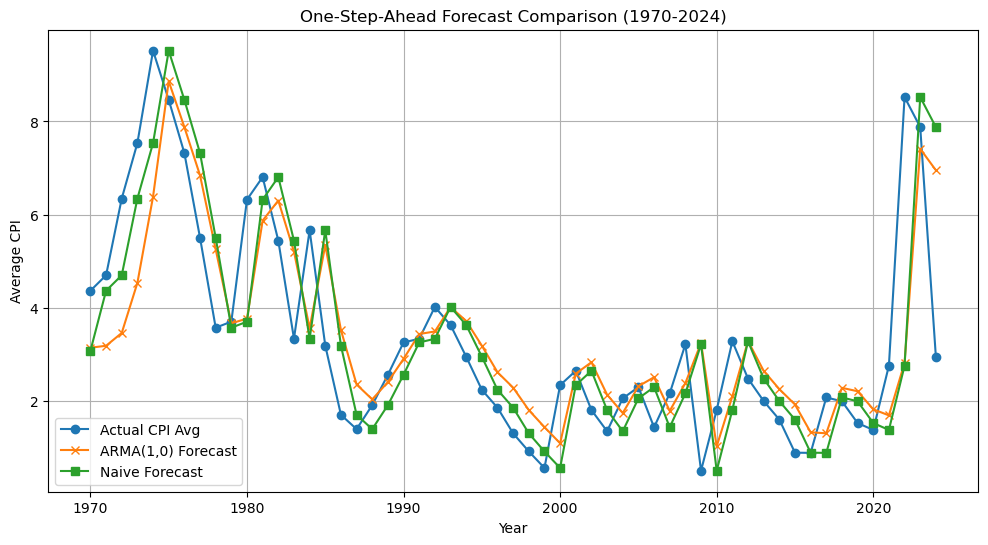

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_results['Year'], forecast_results['Actual'], label='Actual CPI Avg', marker='o')
plt.plot(forecast_results['Year'], forecast_results['ARMA_Forecast'], label=f'ARMA({arma_order[0]},{arma_order[2]}) Forecast', marker='x')
plt.plot(forecast_results['Year'], forecast_results['Naive_Forecast'], label='Naive Forecast', marker='s')
plt.title(f'One-Step-Ahead Forecast Comparison ({forecast_start_year}-{end_year})')
plt.xlabel('Year')
plt.ylabel('Average CPI')
plt.legend()
plt.grid(True)
plt.show()